# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


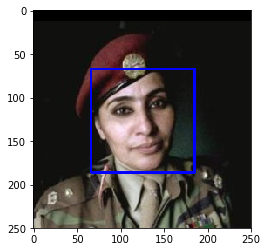

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

face_detector(human_files[3])

True

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ Human faces in human files short is detected at 100% whereas the humans in dog files short is detected at 11% . 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

# calculate percentage of detected human faces in human_files
results = []
for file in (human_files_short):
    results.append(face_detector(file))
np_results_humans = np.array(results)
print("detected faces in human files: {}".format(np.sum(np_results_humans)))

# calculate percentage of detected human faces in dog_files
results = []
for file in (dog_files_short):
    results.append(face_detector(file))
np_results_dogs = np.array(results)
print("detected faces in dog files: {}".format(np.sum(np_results_dogs)))

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

detected faces in human files: 100
detected faces in dog files: 11


In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ the percentage of dog images in human files short is 0, whereas the percentage of dog images in dog files short is 100

In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
results = []
for file in tqdm(human_files_short):
    results.append(dog_detector(file))
np_human_results = np.array(results)
print("percentage of detected dogs in human files: {} %".format(np.sum(np_human_results)))

# calculate percentage of detected human faces in dog_files
results = []
for file in tqdm(dog_files_short):
    results.append(dog_detector(file))
np_dog_results = np.array(results)
print("percentage of detected dogs in dog files: {} %".format(np.sum(np_dog_results)))

  3%|▎         | 3/100 [00:00<00:03, 26.16it/s]

percentage of detected dogs in human files: 0 %


100%|██████████| 100/100 [00:04<00:00, 24.51it/s]

percentage of detected dogs in dog files: 100 %


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 102.47it/s]


In [13]:
import os
import PIL
from PIL import Image


def find_corrupt_images(dataset_path):
    corrupt_images = []
    corrupt_count = 0

    for filename in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, filename)

        try:
            # Attempt to open the image
            with Image.open(file_path) as img:
                img.load()

        except (IOError, SyntaxError, OSError, Image.DecompressionBombError) as e:
            # Append the filename of the corrupt image to the list
            corrupt_images.append(filename)
            #print(f"Error opening image: {filename} - {e}")
            corrupt_count +=1

    return corrupt_images

# Specify the path to your dataset directory
dataset_path = '../../../data/dog_images/train'
# Call the function to find the filenames of the corrupt images
corrupt_image_filenames = find_corrupt_images(dataset_path)

# Print the filenames of the corrupt images
print("Corrupt image filenames:")
for filename in corrupt_image_filenames:
    print(filename)

# Interestingly all three , train, test and valid have 133 corrupt images and they are the same images. this number is small when 
#compared to the tota training images of 6680. But the test images accuracy is envisaged to go down for 133 images . we will see




Corrupt image filenames:
103.Mastiff
059.Doberman_pinscher
055.Curly-coated_retriever
031.Borzoi
024.Bichon_frise
049.Chinese_crested
067.Finnish_spitz
130.Welsh_springer_spaniel
019.Bedlington_terrier
115.Papillon
126.Saint_bernard
013.Australian_terrier
116.Parson_russell_terrier
107.Norfolk_terrier
133.Yorkshire_terrier
032.Boston_terrier
108.Norwegian_buhund
028.Bluetick_coonhound
066.Field_spaniel
129.Tibetan_mastiff
005.Alaskan_malamute
102.Manchester_terrier
034.Boxer
068.Flat-coated_retriever
089.Irish_wolfhound
104.Miniature_schnauzer
035.Boykin_spaniel
080.Greater_swiss_mountain_dog
007.American_foxhound
112.Nova_scotia_duck_tolling_retriever
025.Black_and_tan_coonhound
072.German_shorthaired_pointer
062.English_setter
029.Border_collie
045.Cardigan_welsh_corgi
105.Neapolitan_mastiff
076.Golden_retriever
063.English_springer_spaniel
078.Great_dane
084.Icelandic_sheepdog
023.Bernese_mountain_dog
091.Japanese_chin
011.Australian_cattle_dog
021.Belgian_sheepdog
041.Bullmastiff
0

In [14]:
import os
from PIL import Image

def count_corrupt_images(dataset_path):
    corrupt_count = 0

    for filename in os.listdir(dataset_path):
        file_path = os.path.join(dataset_path, filename)

        try:
            # Attempt to open the image
            with Image.open(file_path) as img:
                img.load()

        except (IOError, SyntaxError, OSError, Image.DecompressionBombError):
            # Increment the corrupt count if an exception is caught
            corrupt_count += 1

    return corrupt_count

# Specify the path to your dataset directory
dataset_path = '../../../data/dog_images/train'

# Call the function to count the number of corrupt images
corrupt_image_count = count_corrupt_images(dataset_path)

print(f"Number of corrupt images: {corrupt_image_count}")


Number of corrupt images: 133


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__  Based on the given architecture 4 hidden layers with filter sizes varying from 16 to 128 is used. The number of strides is 1 and while MaxPooling the pool size and the stride is taken as 2. In addition we have added two fully connected layers of 1024 and 512 nodes. Dropout is a regularization technique that aids in preventing overfitting, improving generalization, and enhancing the robustness of CNN models by randomly dropping out units during training. Finally Dense layer of 133 units, for 133 categories of dogs is used. Activation functions in FC layers are ReLu and finally for the output layer we used softmax function . 

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=16, kernel_size = (2,2), strides = (1,1), padding='valid', activation='relu',input_shape=(224,224,3) ))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=32, kernel_size= (2,2), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters=64, kernel_size = (2,2), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size = (2,2), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size = (2,2), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters=512, kernel_size = (2,2), strides=(1,1), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())

#model.add(Flatten())

model.add(Dense(1024,activation='relu') ) 
model.add(Dropout(0.4))
model.add(Dense(512,activation='relu') ) 
model.add(Dropout(0.4))

model.add(Dense(133,activation='softmax'))
          
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)       32896     
__________

### Compile the Model

In [16]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [17]:
#Augment the training data 
from keras.preprocessing.image import ImageDataGenerator

# train tensors and valid tensors have already been scaled /255
# create and configure augmented image generator

x_train = train_tensors
y_train = train_targets
x_valid = valid_tensors
y_valid = valid_targets

datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(x_train)
datagen_valid.fit(x_valid)



from keras.callbacks import ModelCheckpoint   

batch_size = 16
epochs = 30

# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', verbose=1, 
                               save_best_only=True)

history = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size)

Epoch 1/30
Epoch 00001: val_loss improved from inf to 4.87707, saving model to saved_models/weights.best.from_scratch.hdf5
 - 58s - loss: 4.9517 - acc: 0.0177 - val_loss: 4.8771 - val_acc: 0.0168
Epoch 2/30
Epoch 00002: val_loss improved from 4.87707 to 4.72858, saving model to saved_models/weights.best.from_scratch.hdf5
 - 56s - loss: 4.6850 - acc: 0.0282 - val_loss: 4.7286 - val_acc: 0.0228
Epoch 3/30
Epoch 00003: val_loss did not improve
 - 56s - loss: 4.5752 - acc: 0.0351 - val_loss: 4.9667 - val_acc: 0.0240
Epoch 4/30
Epoch 00004: val_loss improved from 4.72858 to 4.35041, saving model to saved_models/weights.best.from_scratch.hdf5
 - 56s - loss: 4.4683 - acc: 0.0393 - val_loss: 4.3504 - val_acc: 0.0505
Epoch 5/30
Epoch 00005: val_loss did not improve
 - 56s - loss: 4.3991 - acc: 0.0462 - val_loss: 5.2210 - val_acc: 0.0481
Epoch 6/30
Epoch 00006: val_loss improved from 4.35041 to 4.27572, saving model to saved_models/weights.best.from_scratch.hdf5
 - 56s - loss: 4.3204 - acc: 0.05

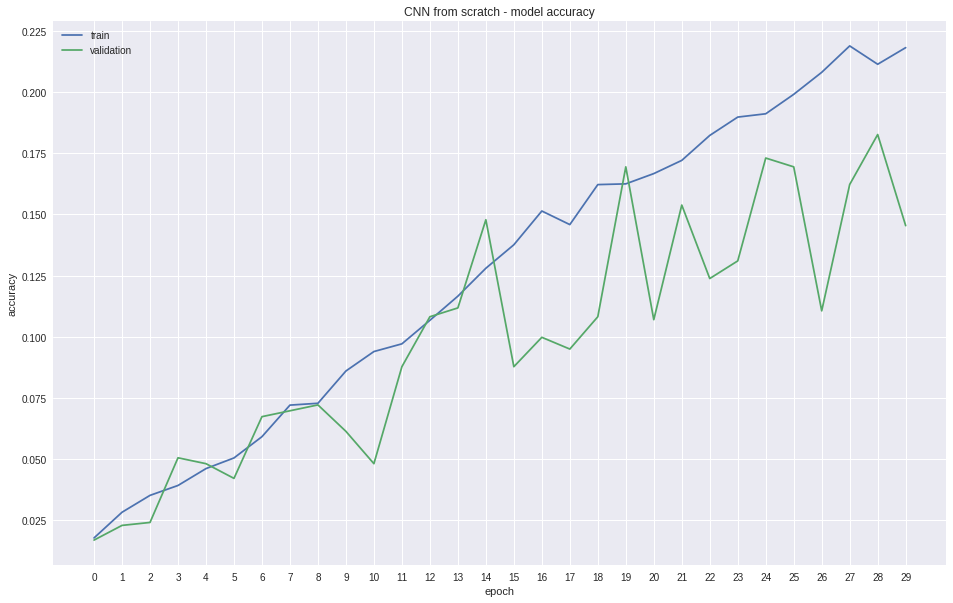

In [22]:
plt.style.use('seaborn')
figure, ax = plt.subplots(1,1, figsize=(16,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN from scratch - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
_ = plt.xticks(range(0, epochs))

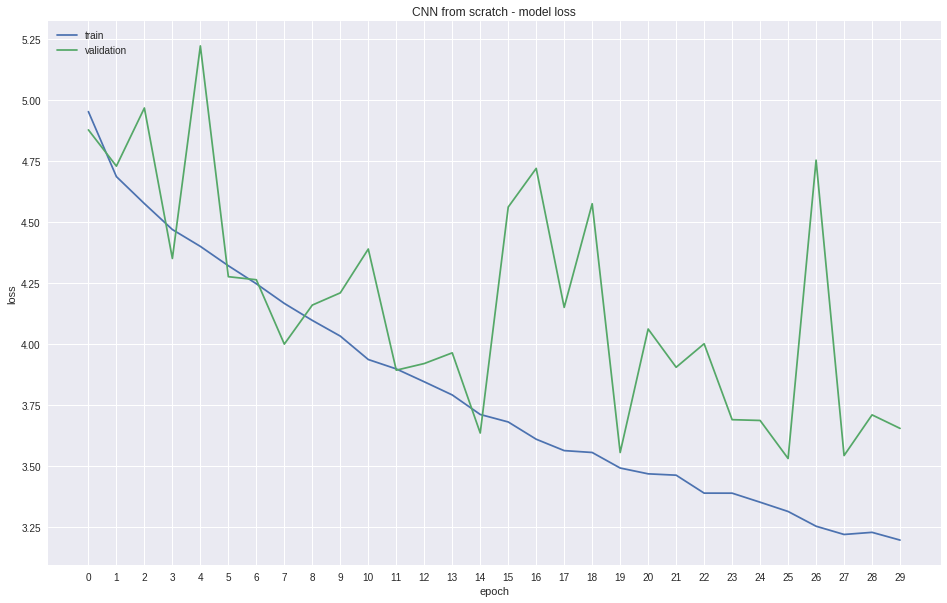

In [23]:
plt.style.use('seaborn')
figure, ax = plt.subplots(1,1, figsize=(16,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN from scratch - model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
_ = plt.xticks(range(0, epochs))

### Load the Model with the Best Validation Loss

In [24]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [25]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 18.6603%


### Load the model for InceptionV3

In [26]:
from keras.applications.inception_v3 import InceptionV3

### Define architecture

In [29]:
base_model = InceptionV3(weights= None, include_top=False)


In [30]:
from keras.models import Model
model_2 = base_model.output
model_2 = GlobalAveragePooling2D()(model_2)
model_2 = Dense(512, activation='relu')(model_2)
model_2 = Dropout(0.4)(model_2)
model_2 = BatchNormalization()(model_2)
predictions = Dense(133, activation='softmax')(model_2)
model_inceptionv3 = Model(inputs=base_model.input, outputs=predictions)

In [31]:
model_inceptionv3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, None, None, 3 96          conv2d_101[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, None, None, 3 0           batch_normalization_98[0][0]     
__________________________________________________________________________________________________
conv2d_102

### Compile Model

In [32]:
model_inceptionv3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics= ['accuracy'])

### Train the model with no data augmentation

In [33]:
# train the model
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_inceptionv3.hdf5', verbose=1, 
                               save_best_only=True)

history2 = model_inceptionv3.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=30, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 245s 37ms/step - loss: 5.1089 - acc: 0.0082 - val_loss: 5.4863 - val_acc: 0.0084
Epoch 2/30
6680/6680 [==============================] - 220s 33ms/step - loss: 4.9860 - acc: 0.0091 - val_loss: 4.9638 - val_acc: 0.0084
Epoch 3/30
6680/6680 [==============================] - 219s 33ms/step - loss: 4.9436 - acc: 0.0081 - val_loss: 9.8735 - val_acc: 0.0060
Epoch 4/30
6680/6680 [==============================] - 218s 33ms/step - loss: 4.8987 - acc: 0.0153 - val_loss: 6.4511 - val_acc: 0.0084
Epoch 5/30
6680/6680 [==============================] - 219s 33ms/step - loss: 4.8773 - acc: 0.0133 - val_loss: 5.6253 - val_acc: 0.0120
Epoch 6/30
6680/6680 [==============================] - 220s 33ms/step - loss: 4.8439 - acc: 0.0169 - val_loss: 4.7867 - val_acc: 0.0180
Epoch 7/30
6680/6680 [==============================] - 219s 33ms/step - loss: 4.7133 - acc: 0.0229 - val_loss: 4.7168 - val_acc: 0

## Here are a few potential reasons why the validation accuracy may not be improving as fast for 10 epochs.

Model Complexity: The model may be too complex and prone to overfitting the training data. Overfitting occurs when the model learns to perform well on the training data but fails to generalize to unseen data. In such cases, increasing the number of epochs could exacerbate the overfitting issue. Instead, consider reducing the model's complexity by adjusting the number of layers, reducing the number of parameters, or applying regularization techniques such as dropout or weight decay.

Insufficient Training Data: We have a small training dataset, the model may struggle to learn robust patterns and generalize well. In such cases, increasing the number of epochs might not be helpful. Instead, consider obtaining more training data or using techniques like data augmentation to artificially increase the dataset's size and diversity.

Learning Rate or Optimizer Issues: The learning rate or the choice of optimizer could be inappropriate for the specific problem or dataset. A learning rate that is too high might cause the model to overshoot optimal parameter values, while a learning rate that is too low could result in slow convergence. Similarly, using a different optimizer or adjusting its hyperparameters (e.g., momentum) might help the model find better optima during training.

Incorrect Model Architecture or Hyperparameters: The model architecture and hyperparameters, such as the number of layers, layer sizes, activation functions, or batch size, might not be well-suited for the specific problem. In such cases, it is necessary to revisit the model design and experiment with different configurations to find a better setup.

When we initialize the weights of the InceptionV3 model using 'imagenet' (referring to the ImageNet dataset), it means that the model is pretrained on a large-scale dataset containing millions of labeled images. This pretraining process enables the model to learn generic features and patterns that are often transferrable to other image-related tasks.

By using the pretrained weights, the model starts with a good initialization point that already captures a wide range of low-level and high-level image features. Consequently, it can leverage this prior knowledge to learn task-specific features more effectively, leading to improved accuracy.

However, when you initialize the weights to 'None' or random values, the model starts with no prior knowledge or pretrained representations. It needs to learn the feature representations from scratch using the training data provided for your specific task. This process requires more training time and a sufficiently large and representative dataset.

Without pretrained weights, the model's performance heavily relies on the quality and quantity of the training data. If you have a limited amount of training data, the model may struggle to learn discriminative features and generalize well to unseen data, resulting in lower accuracy compared to using pretrained weights.

### Plot training and validation accuracy with number of epochs

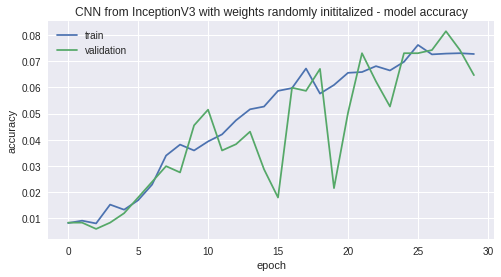

In [34]:
plt.style.use('seaborn')
figure, ax = plt.subplots(1,1, figsize=(8,4))
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('CNN from InceptionV3 with weights randomly inititalized - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### Load Weights with best validation loss

In [35]:
model_inceptionv3.load_weights('saved_models/weights.best.from_scratch_inceptionv3.hdf5')

### Test models accuracy

In [36]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions1 = [np.argmax(model_inceptionv3.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy_inceptionv3 = 100*np.sum(np.array(dog_breed_predictions1)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions1)
print('Test accuracy using InceptionV3 with random weights initialized for 10 epochs only: %.4f%%' % test_accuracy_inceptionv3)

Test accuracy using InceptionV3 with random weights initialized for 10 epochs only: 7.2967%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [23]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [24]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [25]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [42]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

history = VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=50, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 1s 178us/step - loss: 5.3458 - acc: 0.6681 - val_loss: 6.6837 - val_acc: 0.5401
Epoch 2/50
6680/6680 [==============================] - 1s 174us/step - loss: 5.3462 - acc: 0.6683 - val_loss: 6.6846 - val_acc: 0.5389
Epoch 3/50
6680/6680 [==============================] - 1s 174us/step - loss: 5.3462 - acc: 0.6683 - val_loss: 6.6968 - val_acc: 0.5365
Epoch 4/50
6680/6680 [==============================] - 1s 176us/step - loss: 5.3457 - acc: 0.6681 - val_loss: 6.7028 - val_acc: 0.5365
Epoch 5/50
6680/6680 [==============================] - 1s 176us/step - loss: 5.3458 - acc: 0.6681 - val_loss: 6.6918 - val_acc: 0.5317
Epoch 6/50
6680/6680 [==============================] - 1s 179us/step - loss: 5.3460 - acc: 0.6683 - val_loss: 6.6863 - val_acc: 0.5365
Epoch 7/50
6680/6680 [==============================] - 1s 178us/step - loss: 5.3460 - acc: 0.6683 - val_loss: 6.6898 - val_acc: 0.5341
E

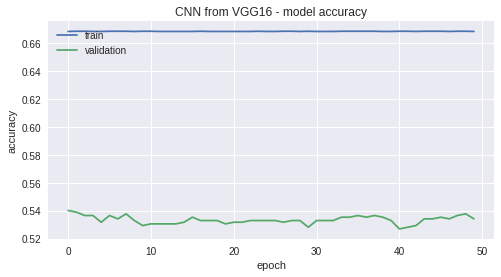

In [43]:
plt.style.use('seaborn')
figure, ax = plt.subplots(1,1, figsize=(8,4))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN from VGG16 - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')


### Load the Model with the Best Validation Loss

In [44]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [45]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 52.3923%


### Predict Dog Breed with the Model

In [46]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [37]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
def bottleneck_features(path = 'bottleneck_features/DogVGG16Data.npz'):
    bottleneck_features = np.load(path)
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']
    
    return train, valid, test
train_InceptionV3, valid_InceptionV3, test_InceptionV3 = bottleneck_features('bottleneck_features/DogInceptionV3Data.npz')

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ We have added GlobalAveragePooling2D for dimensionality reduction for faster handling.
 Next have used 1 fully connected dense layers, for 1024 nodes with an added Dropout function, to prevent overfitting and BatchNormalization ( Batch normalization normalizes the activations of a layer by subtracting the batch mean and dividing by the batch standard deviation. This process helps to center and scale the activations, ensuring they are within a suitable range. This normalization aids in improving the flow of gradients during backpropagation, making it easier for the network to learn and speed up the training process.) 



In [38]:
### TODO: Define your architecture.
from keras.layers import Dropout, BatchNormalization, GlobalAveragePooling2D, Dense, MaxPooling2D
from keras.models import Sequential
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dropout(0.4))
InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dense(1024, activation='relu'))
InceptionV3_model.add(Dropout(0.4))
InceptionV3_model.add(BatchNormalization())
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_193 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_194 (Bat (None, 1024)              4096      
_________________________________________________________________
dense_7 (Dense)              (None, 133)               136325    
Total para

### (IMPLEMENTATION) Compile the Model

In [39]:
### TODO: Compile the model.
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [40]:
### TODO: Train the model.
from keras.callbacks import ModelCheckpoint  

epochs = 30

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_history = InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=epochs, batch_size=16, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/30
6680/6680 [==============================] - 7s 1ms/step - loss: 3.1088 - acc: 0.3493 - val_loss: 0.8895 - val_acc: 0.7569
Epoch 2/30
6680/6680 [==============================] - 4s 581us/step - loss: 1.3109 - acc: 0.6698 - val_loss: 0.6086 - val_acc: 0.8180
Epoch 3/30
6680/6680 [==============================] - 4s 580us/step - loss: 0.9456 - acc: 0.7421 - val_loss: 0.5354 - val_acc: 0.8323
Epoch 4/30
6680/6680 [==============================] - 4s 580us/step - loss: 0.7928 - acc: 0.7729 - val_loss: 0.5083 - val_acc: 0.8455
Epoch 5/30
6680/6680 [==============================] - 4s 579us/step - loss: 0.7058 - acc: 0.7907 - val_loss: 0.4867 - val_acc: 0.8467
Epoch 6/30
6680/6680 [==============================] - 4s 575us/step - loss: 0.6313 - acc: 0.8190 - val_loss: 0.4894 - val_acc: 0.8443
Epoch 7/30
6680/6680 [==============================] - 4s 581us/step - loss: 0.5887 - acc: 0.8207 - val_loss: 0.4793 - val_acc: 0.8539
Epo

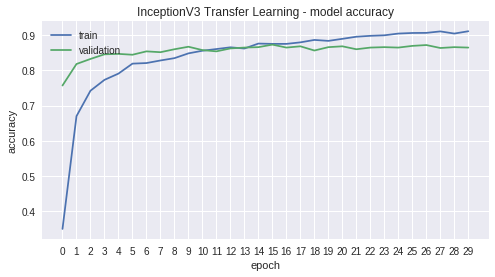

In [41]:
plt.style.use('seaborn')
plt.figure(figsize=(8,4))
plt.plot(InceptionV3_history.history['acc'])
plt.plot(InceptionV3_history.history['val_acc'])
plt.title('InceptionV3 Transfer Learning - model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
_ = plt.xticks(range(0, epochs))

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [42]:
### TODO: Load the model weights with the best validation loss.
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [43]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.9378%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [44]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def InceptionV3_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = InceptionV3_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]




In [45]:
# test call with a test image
InceptionV3_predict_breed('images/American_water_spaniel_00648.jpg')

87916544/87910968 [==============================] - 1s 0us/step


'ages/train/009.American_water_spaniel'

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [46]:
def display_breed_image(name_of_breed):
    """
    shows 5 images of specific dog breed.
    INPUT:
        name_of_breed: name of the breed
    
    """
    fig, ax = plt.subplots(1, 5, figsize=(16,8))
    img_idx =  np.flatnonzero(np.core.defchararray.find(train_files,name_of_breed)!=-1)
    for i, idx in enumerate(np.random.choice(img_idx, 5)):
        plt.subplot(1,5, i+1)
        img = cv2.imread(train_files[idx])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)

In [47]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
# our final algorithm:
def identify_dog_image(img_path):
    """
    If a dog is detected in the image, it will point out to the closest dog's breed.
    If a human is detected, it will identify the dog breed that is most resembling.
    INPUT:
        img_path: path of image input
    
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # output image input
    plt.imshow(img)
    dog_breed = InceptionV3_predict_breed(img_path)
    hint_text = ", like the ones on the 5 images below the input picture."
    text = "I am sorry but there is no humans or dogs in this image, but the resemblance would be similar to " + dog_breed + hint_text
    
    if (dog_detector(img_path)):
        text = "It's a dog. I think it could be a " + dog_breed + hint_text
    elif (face_detector(img_path)):
        text = "Definitely human!!! but if you were a dog you could be a " + dog_breed + hint_text
    else:
        print("Neither human nor dog detected in the image.")
        return None
    
    # output text
    print(text)
    # output 4 sample images of the recognized dog breed:
    display_breed_image(dog_breed)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is definitely good, with the model's test accuracy at 83%. But there is always room for more improvement
We have tried data augmentation on CNN from scratch (Step3) to find that accuracy is merely 11%.
When we tried to use InceptionV3 pretrained model, with weights randomly initialized we found that the loss decreases at a lower rate.Also due to computational time we restricted the epochs to 10 but the issue could be due to insufficient training data set. We have also compromised on addition of fully connected layers , which increases the number of parameters and hence the run-time. 
Another factor to weigh in would be that the CNN architecture needs to be relooked at , reducing or increasing layers from the original architecture or to introduce hyperparameterization( to check for learning rates and momentum).
We can always improve the human face detector by choosing MTCNN instead of OpenCV's Haar based Classifier. 

It's a dog. I think it could be a ages/train/096.Labrador_retriever, like the ones on the 5 images below the input picture.


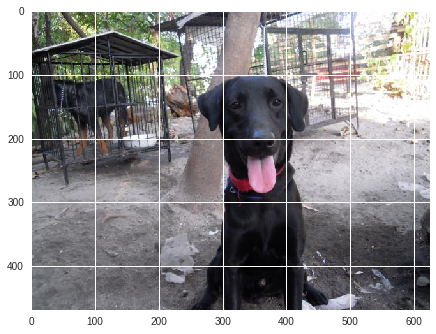

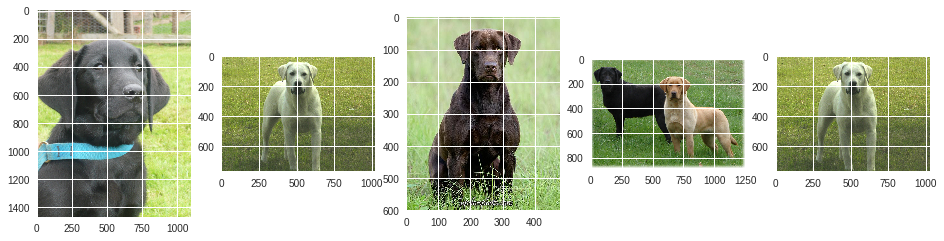

In [48]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

identify_dog_image('images/Labrador_retriever_06449.jpg')

Neither human nor dog detected in the image.


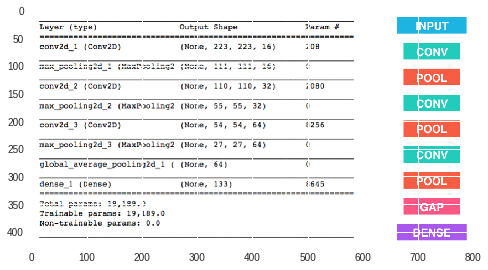

In [49]:
identify_dog_image('images/sample_cnn.png')

Definitely human!!! but if you were a dog you could be a ages/train/126.Saint_bernard, like the ones on the 5 images below the input picture.


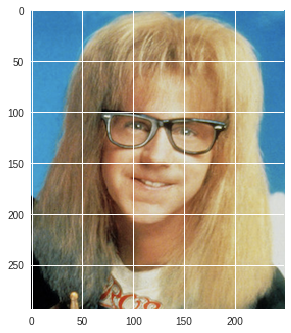

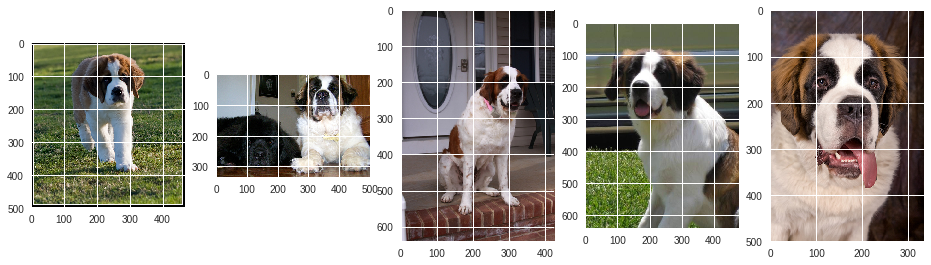

In [50]:
identify_dog_image('images/sample_human_2.png')

Definitely human!!! but if you were a dog you could be a ages/train/077.Gordon_setter, like the ones on the 5 images below the input picture.


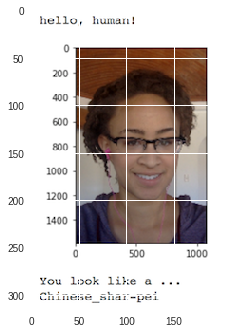

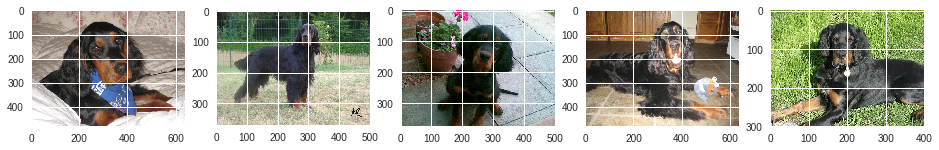

In [51]:
identify_dog_image('images/sample_human_output.png')